# Prediction NHL Player Salaries from Statistical Data

Data sourced from Kaggle: https://www.kaggle.com/camnugent/predict-nhl-player-salaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Load Data

Note: The "clean" data has all [Entry-Level Contracts](https://www.dkpittsburghsports.com/2020/10/10/nhl-waivers-contracts-faq-tlh) removed from the dataset. In the context of NHL player salaries, an ELC is standardized by the NHLPA and will never change (thus, there is nothing to predict). These were considered as irrelevant data points and removed from the dataset. 

In [26]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_clean.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')

### 1.1 Prepare the feature matrix and target vector
Loading the data into feature matrix `X` and target vector `y`.

In [4]:
X = data.iloc[:,2:28]  #Independent Columns. Removed the "Name" Column as it has no significance
y = data.iloc[:,0]     #Target column (salary)

#print dimensions and type of both X and y
print("Feature matrix X: shape:",X.shape,", type:",type(X))
print("Target vector y: shape:",y.shape,", type:",type(y))

Feature matrix X: shape: (766, 24) , type: <class 'pandas.core.frame.DataFrame'>
Target vector y: shape: (766,) , type: <class 'pandas.core.series.Series'>


## 2. Data Visualization

### 2.1. Plotting Age Distribution in NHL

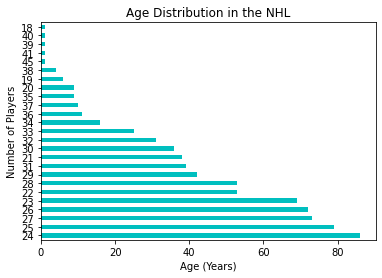

In [5]:
# Plotting Age Data #
raw_data['Age'].value_counts().plot(kind='barh',color='c')
plt.ylabel('Number of Players')
plt.xlabel('Age (Years)')
plt.title('Age Distribution in the NHL')
plt.show()

### 2.2. Plotting Nationality Distribution in NHL

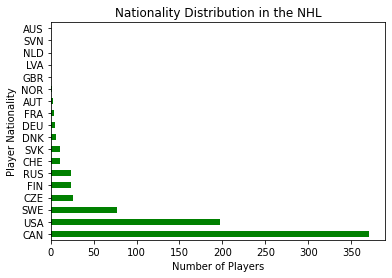

In [6]:
# Country Data #
raw_data['Country'].value_counts().plot(kind='barh',color='g')
plt.ylabel('Player Nationality')
plt.xlabel('Number of Players')
plt.title('Nationality Distribution in the NHL')
plt.show()

### 2.3. Plotting Salary Distribution in NHL

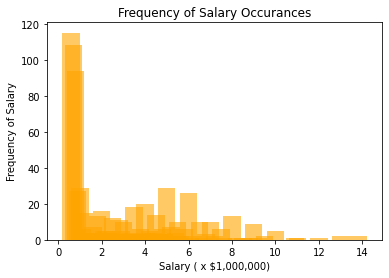

In [7]:
# Salary Data #
salary=raw_data['Salary'].values
salary2=salary.round(-5)

salaries,count = np.unique(salary2, return_counts=True)
salaries=salaries/1000000

plt.bar(salaries, count, align='center', alpha=0.6,color='orange')

plt.ylabel('Frequency of Salary')
plt.xlabel('Salary ( x $1,000,000)')
plt.title('Frequency of Salary Occurances')

plt.show()

## 3. Using KBest for Feature Importance

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(10,'Score'))

           Specs          Score
21    Career PTS  137881.066634
18     Career GP  137805.399012
20      Career A   86742.569204
19      Career G   55081.789735
3          Draft   25626.732021
13  PTS Last Szn    9396.547759
12    A Last Szn    6316.911570
10   GP Last Szn    5666.387842
11    G Last Szn    3656.739204
7        Seasons    1214.871781


In [9]:
cleaned_data=data[['Career PTS', 'Career GP', 'Career A','Career G','Draft','PTS Last Szn','A Last Szn','GP Last Szn','G Last Szn','Seasons']]
X_train, X_test, y_train, y_test = train_test_split(cleaned_data, y, test_size=0.2, random_state=0)

## 4. Compare models using cross-validation

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

def get_regressor_neg_rms(model, X, y, cv=7):
    rms = cross_validate(model,X,y,cv=cv,scoring='r2',return_train_score=True)
    
    return np.average(rms['train_score']),np.average(rms['test_score'])

In [11]:
from sklearn.linear_model import LinearRegression #import LinearRegression
from sklearn.ensemble import RandomForestRegressor #import RandomForestRegerssor
from sklearn.ensemble import GradientBoostingRegressor #import Gradient-boosted regressor

LR_models = [LinearRegression(), RandomForestRegressor(random_state=64),GradientBoostingRegressor(random_state=79)]

for model in LR_models:
    print('\033[1m',type(model).__name__,'\033[0mnegative root mean square')
    train_rms, val_rms = get_regressor_neg_rms(model,X_train,y_train)
    print("\tTraining scores: ",np.around(train_rms,2))
    print("\tValidation scores: ",np.around(val_rms,2),"\n")

 LinearRegression negative root mean square
	Training scores:  0.63
	Validation scores:  0.59 

 RandomForestRegressor negative root mean square
	Training scores:  0.96
	Validation scores:  0.68 

 GradientBoostingRegressor negative root mean square
	Training scores:  0.94
	Validation scores:  0.66 



## 5. Hyperparameter tuning using grid search

### 5.1 Grid search for RandomForestRegressor

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 500],
             'max_depth': [ 11, 13, 15, 17],
             'max_features': ['auto', 'log2', None]}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=64), param_grid, cv=7,scoring='r2')

In [19]:
grid_rf.fit(X_train,y_train)

GridSearchCV(cv=7, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=64,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [20]:
print("Best parameters for RandomForestRegrssor: ",grid_rf.best_params_)
print("Best Score for RandomForestRegrssor: {:.2f}".format(grid_rf.best_score_))

Best parameters for RandomForestRegrssor:  {'max_depth': 17, 'max_features': 'log2', 'n_estimators': 100}
Best Score for RandomForestRegrssor: 0.70


### 5.2 Grid search for gradient boosted tree

In [21]:
param_grid = {'n_estimators': [100, 200, 500],
             'max_depth': [1, 3, 5, 7],
             'learning_rate': [0.01, 0.1, 1.0]}

grid_gbt = GridSearchCV(GradientBoostingRegressor(random_state=79), param_grid, cv=7,scoring='r2')

In [22]:
grid_gbt.fit(X_train,y_train)

GridSearchCV(cv=7, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [23]:
print("Best parameters for GradientBoostedTree: ",grid_gbt.best_params_)
print("Best Score for GradientBoostedTree: {:.2f}".format(grid_gbt.best_score_))

Best parameters for GradientBoostedTree:  {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200}
Best Score for GradientBoostedTree: 0.68


## 6. Retrain best model

In [24]:
best_model = grid_rf.best_estimator_
best_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=17, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=64, verbose=0, warm_start=False)

## 7. Evaluate best model on training and test data

In [25]:
from sklearn.metrics import r2_score

def return_scores(X_data,y_data):
    y_predict = best_model.predict(X_data)
    mse = np.sqrt(mean_squared_error(y_data,y_predict))
    r2 = r2_score(y_data,y_predict)
    print("Root mean-squared error: {:.2f}".format(mse))
    print("R-squared: {:.3f}".format(r2),"\n")
    
##training data
print("\033[1mTraining scores\033[0m")
return_scores(X_train,y_train)

##testing data
print("\033[1mTest scores\033[0m")
return_scores(X_test,y_test)


Training scores
Root mean-squared error: 524055.91
R-squared: 0.957 

Test scores
Root mean-squared error: 1243710.96
R-squared: 0.764 



## 8. Testing a Real-World Example

Now, we will test a real world example of Jesse Puljujarvi. Puljujarvi signed a contract worth [$1.175M in 2021](https://www.capfriendly.com/players/jesse-puljujarvi). Let's see if our model can predict that based on his stats before he signed this contract. 

In [69]:
puljujarvi = (test_data.iloc[23:24,2:28])[['Career PTS', 'Career GP', 'Career A','Career G','Draft','PTS Last Szn','A Last Szn','GP Last Szn','G Last Szn','Seasons']]
puljujarvi_salary=best_model.predict(puljujarvi)[0]
error = np.round(np.abs(puljujarvi_salary-1175000)/1175000*100,2)

print("Our model predicts Jesse Puljujarvi's next contract to be worth: $",puljujarvi_salary,"M")
print("Percent error: ",error,"%")

Our model predicts Jesse Puljujarvi's next contract to be worth: $ 1052100.0 M
Percent error:  10.46 %
